In [1]:
import logging

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

In [2]:
import pandas as pd

nome_arquivo = f'2.atributos.parquet'
df = pd.read_parquet(nome_arquivo)
df = df[:100000]

In [ ]:
import numpy as np

def _adicionar_lag_features(df):
    # assumindo que df é de apenas um município único
    # df está ordenado por data

    df["novos_casos_novos_lag_1"] = df['novos_casos_novos'].shift(1)
    df["obitos_novos_lag_1"] = df['obitos_novos'].shift(1)

    df["novos_casos_novos_lag_7"] = df['novos_casos_novos'].shift(7)
    df["obitos_novos_lag_7"] = df['obitos_novos'].shift(7)

    df["novos_casos_novos_lag_14"] = df['novos_casos_novos'].shift(14)
    df["obitos_novos_lag_14"] = df['obitos_novos'].shift(14)

    return df

def _adicionar_media_movel_7(df):
    # assumindo que df é de apenas um município único
    # df está ordenado por data

    df['novos_casos_novos_media_movel_7'] = df['novos_casos_novos'].transform(lambda x: x.shift(1).rolling(7).mean())
    df['obitos_novos_media_movel_7'] = df['obitos_novos'].transform(lambda x: x.shift(1).rolling(7).mean())

    return df

def _adicionar_tempo_ate_primeiro_caso(df):
    primeiro_caso = df.loc[df["novos_casos_novos"] > 0, "data"].iloc[0]
    primeiro_dia = df.iloc[0]['data']

    tempo_ate_primeiro_caso = primeiro_caso - primeiro_dia
    
    df['tempo_ate_primeiro_caso'] = tempo_ate_primeiro_caso.days
    df['evento_primeiro_caso'] = 1
    
    return df

def _adicionar_tempo_ate_primeiro_obito(df):
    primeiro_caso = df.loc[df["obitos_novos"] > 0, "data"].iloc[0]
    primeiro_dia = df.iloc[0]['data']

    tempo_ate_primeiro_obito = primeiro_caso - primeiro_dia
    
    df['tempo_ate_primeiro_obito'] = tempo_ate_primeiro_obito.days
    df['evento_primeiro_obito'] = 1
    
    return df


In [ ]:
def _rodar_engenharia_de_atributos(df):
    df = _adicionar_lag_features(df)
    df = _adicionar_media_movel_7(df)
    df = _adicionar_tempo_ate_primeiro_caso(df)
    df = _adicionar_tempo_ate_primeiro_obito(df)

    return df

In [5]:
from tqdm import tqdm

def _processar(df):
    logging.info("Processando municipios_unicos")
    municipios_unicos = set(zip(df['municipio'], df['estado']))
    logging.info("Processamento concluído")

    logging.info("Filtrando o dataframe ")
    mascara = df.apply(lambda x: (
        x['municipio'], x['estado']) in municipios_unicos, axis=1)
    filtrado_df = df[mascara]
    logging.info("Processamento concluído")

    logging.info("Processando grupos")
    agrupado = filtrado_df.groupby(['municipio', 'estado'])
    logging.info("Processamento concluído")

    resultado_df = []

    for (municipio, estado), group_df in tqdm(agrupado, desc="Processando"):
        try:
            group_df = group_df.sort_values(by='data')
            resultado_df.append(_rodar_engenharia_de_atributos(group_df))
        except Exception as e:
            logging.error(f"{estado}_{municipio} não foi salvo")
            logging.error(e)

    resultado_df = pd.concat(resultado_df)
    return resultado_df

In [6]:
df = _processar(df)

2025-05-27 10:54:01 - INFO - Processando municipios_unicos
2025-05-27 10:54:01 - INFO - Processamento concluído
2025-05-27 10:54:01 - INFO - Filtrando o dataframe 
2025-05-27 10:54:02 - INFO - Processamento concluído
2025-05-27 10:54:02 - INFO - Processando grupos
2025-05-27 10:54:02 - INFO - Processamento concluído
Processando: 100%|██████████| 55/55 [00:00<00:00, 134.57it/s]


In [7]:
df.columns

Index(['regiao', 'estado', 'municipio', 'coduf', 'codmun', 'cod_regiao_saude',
       'nome_regiao_saude', 'data', 'semana_epi', 'populacao_tcu_2019',
       'casos_acumulados', 'casos_novos', 'obitos_acumulados', 'obitos_novos',
       'interior_metropolitana', 'novos_casos_novos', 'novos_casos_acumulados',
       'mes', 'mes_traduzido', 'dia_semana', 'dia_semana_traduzido', 'estacao',
       'novos_casos_novos_lag_1', 'obitos_novos_lag_1',
       'novos_casos_novos_lag_7', 'obitos_novos_lag_7',
       'novos_casos_novos_lag_14', 'obitos_novos_lag_14',
       'novos_casos_novos_media_movel_7', 'obitos_novos_media_movel_7',
       'tempo_ate_primeiro_caso', 'tempo_ate_primeiro_obito',
       'evento_primeiro_caso', 'evento_primeiro_obito'],
      dtype='object')

In [12]:
import pandas as pd
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Auto-detect display width
pd.set_option('display.max_colwidth', None)  # Show full content of each cell

df[df['municipio'] == "Abadia dos Dourados"][['novos_casos_novos', 'obitos_novos', 'tempo_ate_primeiro_caso', 'data', 'tempo_ate_primeiro_obito', 'evento_primeiro_caso', 'evento_primeiro_obito']].head(71)

,novos_casos_novos,obitos_novos,tempo_ate_primeiro_caso,data,tempo_ate_primeiro_obito,evento_primeiro_caso,evento_primeiro_obito
1849,0,0,42,2020-03-27,70,1,1
1850,0,0,42,2020-03-28,70,1,1
1851,0,0,42,2020-03-29,70,1,1
1852,0,0,42,2020-03-30,70,1,1
1853,0,0,42,2020-03-31,70,1,1
1854,0,0,42,2020-04-01,70,1,1
1855,0,0,42,2020-04-02,70,1,1
1856,0,0,42,2020-04-03,70,1,1
1857,0,0,42,2020-04-04,70,1,1
1858,0,0,42,2020-04-05,70,1,1


In [9]:
df[df['tempo_ate_primeiro_caso'] == 1]

,regiao,estado,municipio,coduf,codmun,cod_regiao_saude,nome_regiao_saude,data,semana_epi,populacao_tcu_2019,casos_acumulados,casos_novos,obitos_acumulados,obitos_novos,interior_metropolitana,novos_casos_novos,novos_casos_acumulados,mes,mes_traduzido,dia_semana,dia_semana_traduzido,estacao,novos_casos_novos_lag_1,obitos_novos_lag_1,novos_casos_novos_lag_7,obitos_novos_lag_7,novos_casos_novos_lag_14,obitos_novos_lag_14,novos_casos_novos_media_movel_7,obitos_novos_media_movel_7,tempo_ate_primeiro_caso,tempo_ate_primeiro_obito,evento_primeiro_caso,evento_primeiro_obito


<Axes: xlabel='data'>

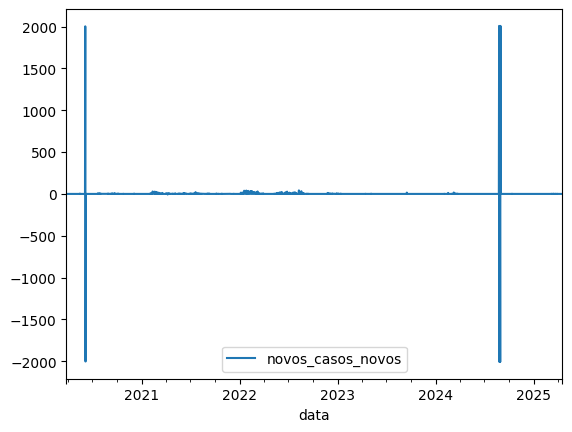

In [10]:
df[df['municipio'] == "Abadia dos Dourados"].plot(x="data", y="novos_casos_novos")